In [165]:
import pandas as pd
import numpy as np 
import csv
import matplotlib.pyplot as plt
import math
from pandas_datareader import data
import scipy.optimize
from scipy import stats

In [166]:
#read tickers from csv file
tickers_file = 'TechTickers.csv'
tickers = [];
f = open(tickers_file, "r", encoding='utf-8-sig')
for line in csv.reader(f):
    tickers.append(str(line[0]))
f.close
#print(tickers)

<function TextIOWrapper.close>

In [167]:
#download price data from Yahoo
start_date = '2009-01-01'
end_date = '2019-12-31'
stock_data = data.get_data_yahoo(tickers, start_date, end_date)

In [168]:
#create a list of tickers whose adjusted closing prices in the first month of the first year
#do not have any missing values
stockArray = []
for ticker in tickers:
    stockArray.append(list(stock_data['Adj Close'][ticker]))
stockArray=np.array(stockArray)
tickers_liq = []
for i in range(len(tickers)):
    temp=0
    for j in range(len(stockArray[i,:])):
        if math.isnan(stockArray[i,j]):
            temp=1
    if (temp==0):
        tickers_liq.append(tickers[i])
#print(len(tickers_liq))

64
['AAPL', 'MSFT', 'TSM', 'INTC', 'CSCO', 'ORCL', 'SAP', 'ADBE', 'CRM', 'NVDA', 'ACN', 'ASML', 'TXN', 'IBM', 'QCOM', 'FIS', 'SNE', 'INTU', 'MU', 'VMW', 'AMAT', 'AMD', 'ADI', 'LRCX', 'INFY', 'ADSK', 'CTSH', 'TEL', 'APH', 'HPQ', 'CAJ', 'ERIC', 'MSI', 'KLAC', 'MCHP', 'XLNX', 'STM', 'VRSN', 'GLW', 'GIB', 'ANSS', 'SNPS', 'WDC', 'SWKS', 'CDNS', 'GRMN', 'MRVL', 'CHKP', 'MXIM', 'STX', 'CTXS', 'AKAM', 'NTAP', 'BR', 'IT', 'LDOS', 'ZBRA', 'TDY', 'OTEX', 'TYL', 'TER', 'FICO', 'JKHY', 'ASX']


In [170]:
#save the list of tickers without any initial missing values
tickers = list(tickers_liq) #use "list" when assigning a list to a new list in case mistakes
np.savetxt("TechTickers_liq.csv",np.array(tickers),fmt='%1s',delimiter=',')

In [171]:
#for the given range of years, download and save all adjusted closing prices for the tickers
#from the list of those without missing initial values
stockArray = []
for ticker in tickers_liq:
    stockArray.append(list(stock_data['Adj Close'][ticker]))
stockArray=np.array(stockArray)
np.savetxt("AdjustedClosingPrices_2009To2019.csv",np.transpose(stockArray),delimiter=',')

In [172]:
#(a) mean return and variance
AnnualizedDay = 250; d = np.shape(stockArray)[0]
AdjPrice_file = "AdjustedClosingPrices_2009To2019.csv"
f = open(AdjPrice_file,"r",encoding='utf-8-sig')
AdjPrice = pd.read_csv('AdjustedClosingPrices_2009To2019.csv', header=None)
AdjPrice = np.array(AdjPrice)

#compute daily return
Ret = AdjPrice[1:,:] / AdjPrice[:-1,:] - 1

RetMean = np.mean(Ret, axis=0)
RetCov = np.cov((Ret).T)
RetMean = RetMean * AnnualizedDay
RetCov = RetCov * AnnualizedDay

#save data
np.savetxt("AnnualizedMean.csv",np.array(RetMean),fmt='%1s',delimiter=',')
np.savetxt("AnnualizedCovariance.csv",np.array(RetCov),fmt='%1s',delimiter=',')

In [13]:
#(b) minimal variance portfolio

def my_obj1(x):
    return np.dot(np.dot(x.T,RetCov),x)

def my_constr1(x):
    return np.sum(x) - 1

constr = {'type': 'eq', 'fun': my_constr1}
x0 = np.zeros(d); x0[0] = 1
opt1 = scipy.optimize.minimize(my_obj1, x0, constraints=constr, options={'maxiter':1e6})
#print(opt1)

#save data
np.savetxt("MinimalVarPort.csv",np.array(opt1.x),fmt='%1s',delimiter=',')

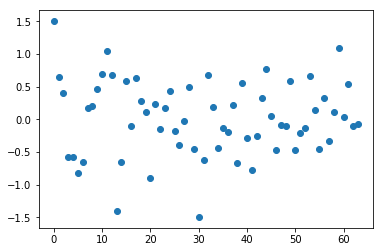

2.142036414973624 1.0257049346650433


In [178]:
#(c) optimal mean-variance portfolio

gamma = 1

def my_obj2(x):
    return gamma * np.dot(np.dot(x.T,RetCov),x) - np.dot(x.T,RetMean)

constr = {'type': 'eq', 'fun': my_constr1}
x0 = np.zeros(d); x0[0] = 1
opt2 = scipy.optimize.minimize(my_obj2, x0, constraints=constr, options={'maxiter':1e6})
#print(opt2)

#save data
np.savetxt("MeanVarPort.csv",np.array(opt2.x),fmt='%1s',delimiter=',')

x = [i for i in range(d)]
y = opt2.x
plt.scatter(x,y)
plt.show()
port2Mean = np.dot((opt2.x).T,RetMean)
port2Var = np.dot(np.dot((opt2.x).T,RetCov),(opt2.x))
print(port2Mean, port2Var)

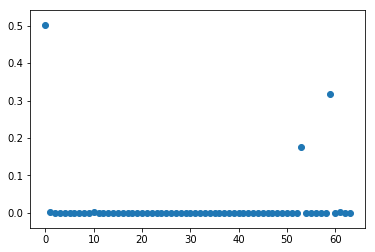

0.5721439844938762 0.05441305132035014 0.041372046946460475


In [187]:
#(d) opt mean-var portfolio

std = [np.sqrt(RetCov[i,i]) for i in range(d)]
std = np.array(std)

upperbd_mean = RetMean + std
lowerbd_mean = RetMean - std
mean_prime = 0.5 * (upperbd_mean + lowerbd_mean)
epsilo = 0.5 * (upperbd_mean - lowerbd_mean)

def my_obj3(x):
    return gamma * np.dot(np.dot(x.T,RetCov),x) - np.dot(x.T,mean_prime) + np.dot(np.abs(x).T,epsilo)

constr = {'type': 'eq', 'fun': my_constr1}
x0 = np.ones(d); x0 = x0/d
opt3 = scipy.optimize.minimize(my_obj3, x0, constraints=constr, options={'maxiter':1e6})
#print(opt3)

#save data
np.savetxt("MeanVarPortwRobust.csv",np.array(opt3.x),fmt='%1s',delimiter=',')

x = [i for i in range(d)]
y = opt3.x
plt.scatter(x,y)
plt.show()
bestcaseMean = np.dot((opt3.x).T,upperbd_mean)
worstcaseMean = np.dot((opt3.x).T,lowerbd_mean)
port3Var = np.dot(np.dot((opt3.x).T,RetCov),(opt3.x))
print(bestcaseMean,worstcaseMean,port3Var)

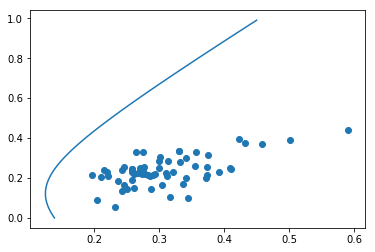

In [16]:
#(e) Compute the efficient frontier

mu = [0.01*i for i in range(100)]
fmu = []

for i in range(100):
    def my_constr2(x):
        return np.dot(x.T,RetMean) - mu[i]
    
    constr = ({'type': 'eq', 'fun': my_constr1},
             {'type': 'eq', 'fun': my_constr2})
    x0 = np.zeros(d); x0[0] = 1
    opt4 = scipy.optimize.minimize(my_obj1, x0, constraints=constr, options={'maxiter':1e6})
    fmu.append(np.sqrt(np.dot(np.dot(opt4.x.T,RetCov),opt4.x)))

plt.plot(fmu,mu)
plt.scatter(std, RetMean)
plt.show()

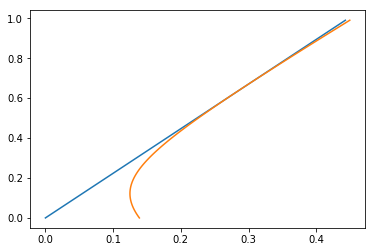

In [157]:
#(f)adding riskless asset
R0 = 0.01
A = RetCov; b = RetMean - R0
MarketPort = np.linalg.solve(A,b)
MarketPort = MarketPort / np.sum(MarketPort)

#save data
np.savetxt("MarketPort.csv",np.array(MarketPort),fmt='%1s',delimiter=',')

#efficient frontier for the extended market
MarketVar = []
MarketMean = np.dot(MarketPort.T,RetMean)
for i in mu:
    alpha0 = (i - MarketMean) / (R0 - MarketMean)
    alphaStar = MarketPort * (1 - alpha0)
    MarketVar.append(np.sqrt(np.dot(np.dot(alphaStar.T,RetCov),alphaStar)))
    
plt.plot(MarketVar,mu)
plt.plot(fmu,mu)
plt.show()

In [188]:
#Now we need to fix our R0 with annualized one to daily one
R0 = R0 / AnnualizedDay

In [189]:
#2(a) compute beta

Beta = np.dot(RetCov,MarketPort) / np.dot(np.dot(MarketPort.T,RetCov),MarketPort)

np.savetxt("Beta.csv",np.array(Beta),fmt='%1s',delimiter=',')

#print(beta)



In [159]:
#2(b) regression with only market
AssetExcessRet = Ret - R0
MarketExcessRet = np.dot(Ret,MarketPort) - R0
a_intercept = []; b_slope = []
for i in range(d):
    slope, intercept, r_value, p_value, std_err = stats.linregress(MarketExcessRet,AssetExcessRet[:,i])
    a_intercept.append(intercept)
    b_slope.append(slope)

    
LS_pair = []
for i in range(d):
    LS_pair.append([a_intercept[i], b_slope[i]])
    
#save data
np.savetxt("LS_pair.csv",np.array(LS_pair),fmt='%1s',delimiter=',')

In [191]:
#2(c) regression with market plus prior 5-day average return

PriAveRet = np.zeros((len(Ret[:,0]) - 5, d))
for i in range(len(Ret[:,0])-5):
    PriAveRet[i,:] = np.mean(Ret[i:i+5,:],axis=0)

a1_intercept = []; c1_slope = []
for i in range(d):
    slope, intercept, r_value, p_value, std_err = stats.linregress(PriAveRet[:,i],AssetExcessRet[5:,i] - Beta[i]*MarketExcessRet[5:])
    a1_intercept.append(intercept)
    c1_slope.append(slope)
    if (p_value > 0.05):
        print(i,p_value)

    
PriAve_pair = []
for i in range(d):
    PriAve_pair.append([a1_intercept[i], c1_slope[i]])
    
#save data
np.savetxt("PriAve_pair.csv",np.array(PriAve_pair),fmt='%1s',delimiter=',')

0 0.701658905309147
3 0.5198115120844933
4 0.2907186737185783
5 0.4691731954383991
9 0.4996929687767754
10 0.05462799266937614
11 0.11026587769966825
13 0.23058770450226923
14 0.2152200302656965
16 0.8856405197016495
17 0.0981428897565581
18 0.48709220517248186
19 0.07053580831891502
20 0.38281732486984665
21 0.6230771533614744
22 0.05279638287417714
23 0.0949264687770727
24 0.4048697243969831
25 0.6585620929206897
29 0.9515549744546671
30 0.2516696599403667
32 0.05584966621168564
33 0.8428354611759885
34 0.6232508537651686
36 0.2692013204119863
37 0.11318484461594158
38 0.44587818050489214
40 0.7700674425385371
42 0.39857343379982
43 0.11778442440328922
46 0.1087723770241307
49 0.38478999999642594
50 0.15766538500555566
51 0.17141057624012643
52 0.908673260161561
53 0.5773131135628535
54 0.9409836621791484
55 0.6674935936330828
56 0.4262445639139627
57 0.9401363050233325
58 0.4258404946647564
60 0.444699875773952
61 0.19426571225102632


In [192]:
#2(d) regression with market plus volume weighted prior 5-day average return

VolumeArray = []
for ticker in tickers_liq:
    VolumeArray.append(list(stock_data['Volume'][ticker]))
VolumeArray=np.array(VolumeArray).T

VWPriAveRet = np.zeros((len(Ret[:,0]) - 5, d))
for i in range(len(Ret[:,0]) - 5):
    for j in range(d):
        VWPriAveRet[i,j] = np.dot(Ret[i:i+5,j].T,VolumeArray[i:i+5,j]) / np.sum(VolumeArray[i:i+5,j])


a2_intercept = []; c2_slope = []
for i in range(d):
    slope, intercept, r_value, p_value, std_err = stats.linregress(VWPriAveRet[:,i],AssetExcessRet[5:,i] - Beta[i]*MarketExcessRet[5:])
    a2_intercept.append(intercept)
    c2_slope.append(slope)
    if (p_value > 0.05):
        print(i,p_value)

    
VWPriAve_pair = []
for i in range(d):
    VWPriAve_pair.append([a2_intercept[i], c2_slope[i]])
 
#save data
np.savetxt("VWPriAve_pair.csv",np.array(VWPriAve_pair),fmt='%1s',delimiter=',')

0 0.6533696582397877
3 0.5321814969671952
4 0.3446810294864542
5 0.3025451577787738
9 0.6840902331203167
10 0.07533078359683112
11 0.13153188392122056
13 0.28212087491565163
14 0.3679473581915943
16 0.8422775013370757
17 0.1734529022809019
18 0.3826427222416584
19 0.42909572811778807
20 0.4024112557063666
21 0.9264931722990082
22 0.06644233510731332
23 0.4225029132924314
24 0.47840373064682384
25 0.5286978286272077
29 0.6915316664325343
30 0.39296378621459016
33 0.866053380624161
34 0.6252275542648627
36 0.7355827202501658
37 0.08680314863717392
38 0.42093119525393485
40 0.8181874984459984
42 0.8980255598865149
43 0.0756125371180306
49 0.22176111467443252
51 0.5185983463478083
52 0.6718296661538655
53 0.8295440943559977
54 0.9984333446911989
55 0.625128901825482
56 0.9661994326254189
57 0.6638956524290271
58 0.6909678260461857
60 0.5837196402976895
61 0.22343785890133225


In [193]:
#2(e) modification
lambda_ = [0.1*i for i in range(10)]
mu_PriAveRet = np.mean(PriAveRet, axis=0)
mu_VWPriAveRet = np.mean(VWPriAveRet, axis=0)

PriAveRet_Cov = np.cov(PriAveRet.T)
VWPriAveRet_Cov = np.cov(VWPriAveRet.T)
sigma_PriAveRet = np.array([np.sqrt(PriAveRet_Cov[i,i]) for i in range(d)])
sigma_VWPriAveRet = np.array([np.sqrt(VWPriAveRet_Cov[i,i]) for i in range(d)])


#finding the subsample for (c) factor
   
opt_lambda1 = []; opt_pvalue1 = []
opt_intercept1 = []; opt_slope1 = []
for j in range(d):
    pvalue1 = 100
    for lam in lambda_:
        c_subsam_index = [];
        for i in range(len(PriAveRet[:,0])):
            if (PriAveRet[i,j] - (mu_PriAveRet[j] + lam * sigma_PriAveRet[j]) > 0):
                c_subsam_index.append(i)
        c_subsam_index = np.array(c_subsam_index)
        
        #get subsample for asset j with lambda equals lam:
        y_for_c = AssetExcessRet[c_subsam_index+5]
        y_for_c = y_for_c[:,j] - Beta[j]*MarketExcessRet[c_subsam_index+5]
        x_for_c = PriAveRet[c_subsam_index]
        x_for_c = x_for_c[:,j]
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_for_c,y_for_c)
        if (p_value < pvalue1):
            pvalue1 = p_value
            optlam_for_c = lam
            optinc_for_c = intercept
            optslope_for_c = slope
    
    opt_lambda1.append(optlam_for_c); opt_pvalue1.append(pvalue1)
    opt_intercept1.append(optinc_for_c); opt_slope1.append(optslope_for_c)
    
    
#finding the subsample for (d) factor

opt_lambda2 = []; opt_pvalue2 = []
opt_intercept2 = []; opt_slope2 = []
for j in range(d):
    pvalue2 = 100
    for lam in lambda_:
        d_subsam_index = [];
        for i in range(len(VWPriAveRet[:,0])):
            if (VWPriAveRet[i,j] - (mu_VWPriAveRet[j] + lam * sigma_VWPriAveRet[j]) > 0):
                d_subsam_index.append(i)
        d_subsam_index = np.array(d_subsam_index)
        
        #get subsample for asset j with lambda equals lam:
        y_for_d = AssetExcessRet[d_subsam_index+5]
        y_for_d = y_for_d[:,j] - Beta[j]*MarketExcessRet[d_subsam_index+5]
        x_for_d = VWPriAveRet[d_subsam_index]
        x_for_d = x_for_d[:,j]
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_for_d,y_for_d)
        if (p_value < pvalue2):
            pvalue2 = p_value
            optlam_for_d = lam
            optinc_for_d = intercept
            optslope_for_d = slope
    
    opt_lambda2.append(optlam_for_d); opt_pvalue2.append(pvalue2)
    opt_intercept2.append(optinc_for_d); opt_slope2.append(optslope_for_d)

opt_pvalue = np.array([opt_pvalue1,opt_pvalue2])

#save data
np.savetxt("Pvalues.csv",np.array(opt_pvalue),fmt='%1s',delimiter=',')

In [194]:
#compute mean excess returns of hedged asset over subsample

##for (c) factor:

ExcessRetMean1 = []; ExcessRetVar1 = []
for j in range(d):
    c_subsam_index = [];
    for i in range(len(PriAveRet[:,0])):
        if (PriAveRet[i,j] - (mu_PriAveRet[j] + opt_lambda1[j] * sigma_PriAveRet[j]) > 0):
            c_subsam_index.append(i)
    c_subsam_index = np.array(c_subsam_index)
    print(len(c_subsam_index))
        
    #get subsample for asset j with lambda:
    y_for_c = AssetExcessRet[c_subsam_index+5]
    y_for_c = y_for_c[:,j] - Beta[j]*MarketExcessRet[c_subsam_index+5]
    ExcessRetMean1.append(np.mean(y_for_c))
    ExcessRetVar1.append(np.var(y_for_c))
    #F1 = PriAveRet[c_subsam_index]; F1 = F1[:,j]
    #ExcessRetMean1.append(np.mean(F1*opt_slope1[j] + opt_intercept1[j]))
    #ExcessRetVar1.append(np.var(F1*opt_slope1[j]))
    
    
    
    
##for (d) factor:

ExcessRetMean2 = []; ExcessRetVar2 = []
for j in range(d):
    d_subsam_index = [];
    for i in range(len(VWPriAveRet[:,0])):
        if (VWPriAveRet[i,j] - (mu_VWPriAveRet[j] + opt_lambda2[j] * sigma_VWPriAveRet[j]) > 0):
            d_subsam_index.append(i)
    d_subsam_index = np.array(d_subsam_index)
    print(len(d_subsam_index))
        
    #get subsample for asset j with lambda:
    y_for_d = AssetExcessRet[d_subsam_index+5]
    y_for_d = y_for_d[:,j] - Beta[j]*MarketExcessRet[d_subsam_index+5]
    ExcessRetMean2.append(np.mean(y_for_d))
    ExcessRetVar2.append(np.var(y_for_d))
    #F2 = VWPriAveRet[d_subsam_index]; F2 = F2[:,j]
    #ExcessRetMean2.append(np.mean(F2*opt_slope2[j]))
    #ExcessRetVar2.append(np.var(F2*opt_slope2[j]))

ExcessRetMean = np.array([ExcessRetMean1,ExcessRetMean2])


#save data
np.savetxt("ExcessRetMean.csv",np.array(ExcessRetMean),fmt='%1s',delimiter=',')

print(np.mean(AssetExcessRet, axis=0))

503
1408
443
493
439
619
1154
466
830
368
1311
878
1161
532
345
407
1356
574
720
1395
1014
541
1398
766
383
566
1103
1433
440
1017
1236
1417
354
630
1133
1401
1190
1086
432
1195
375
1453
577
552
1421
1381
1381
1285
1114
927
483
636
998
1015
379
1384
452
1445
922
1432
1223
429
563
1378
1004
1421
447
498
502
1417
901
979
922
348
1305
677
1023
1403
360
739
949
859
1407
1389
1151
1241
694
430
374
468
1355
745
573
355
1376
1394
1034
1427
568
397
477
1094
436
1346
615
1170
1255
847
526
1372
1374
1000
573
935
464
340
1255
419
368
1082
1102
470
356
891
1233
520
563
1406
[0.00127857 0.00091328 0.00095342 0.00071217 0.00056207 0.00050789
 0.00061948 0.00110226 0.00127943 0.0015372  0.00080493 0.00130776
 0.00094449 0.00031749 0.00054177 0.00087103 0.00063424 0.00097061
 0.0015229  0.00097998 0.00087803 0.00171205 0.00085912 0.00116053
 0.00095848 0.00100162 0.00081825 0.00082913 0.00090249 0.00038256
 0.00018385 0.00036548 0.00094622 0.00109381 0.00084883 0.00083054
 0.00093992 0.00097914 0.0006

In [197]:
#compute the corresponding sharpe ratio
## for factor in (c)
SharpeRatio1 = []
for i in range(d):
    SharpeRatio1.append(ExcessRetMean1[i] / np.sqrt(ExcessRetVar1[i]))

##for factor in (d)
SharpeRatio2 = []
for i in range(d):
    SharpeRatio2.append(ExcessRetMean2[i] / np.sqrt(ExcessRetVar2[i]))

## for entire sample
Entire_SharpeRatio = []
for i in range(d):
    Entire_SharpeRatio.append(np.mean(AssetExcessRet[i]) / np.sqrt(np.var(AssetExcessRet[i])))
    

print(SharpeRatio1)
print(SharpeRatio2)
print(Entire_SharpeRatio)

[0.06745898770067432, -0.03449614600506907, -0.04725186157179072, -0.08521505246134364, -0.0763497485440865, 0.007708215985695938, -0.008869264992500679, -0.03206337325229879, -0.027139730766415713, -0.05000618967765191, -0.02639218903468627, -0.0008000131729051258, -0.026467548187108256, -0.07820808845093745, -0.010884129069715398, -0.10091096766920109, -0.011106741974175091, -0.017787596994518057, 0.004941232420612162, -0.02255452963589173, -0.005811320040425095, 0.01435918581835689, -0.044467237437608345, -0.038951406587374685, -0.014326269857472726, 0.02468666106018581, -0.07040756072355434, 0.025096279076690015, -0.043295667051494756, -0.02834693273068608, -0.03237517918221567, -0.016756376090144662, -0.08475327930311674, -0.0013503442594109353, 0.018634223938731296, -0.011975847798589918, -0.0022785845286509704, 0.025194777094726645, 0.014651231626949405, -0.02881456512282829, 0.04349057010001474, -0.027690777353571845, -0.006212305123747826, -0.0086855280507965, -0.0200409466181